> __**** Projet 7 : Détectez les Bad Buzz grâce au Deep Learning ****__



Ce projet consiste à créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux.
Il doit être capable de prédire le sentiment associé à chaque commentaire ou tweet

Nous allons présenter ici 3 approches :
   
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment.

- approche “Modèle sur mesure simple” en utilisant le service Azure Machine Learning Studio pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.(voir le modèle ML) studio

- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet.

In [30]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout,Bidirectional,LSTM
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

from keras.layers import Flatten
from keras.layers.embeddings import Embedding

import numpy as np
import pandas as pd
import os
import json
import timeit
import re
from keras.datasets import imdb
from nltk.corpus import stopwords

top_words = 10000

# Préparation des données

## Lecture et chargement du fichier 

In [2]:
DF=pd.read_csv('Data_P7.csv')

In [3]:
# showing the list of data cleanning operation
DF.head(10).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#7CAE00'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#DCDCDC')]}, 
 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
 {'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}

]
).hide_index()

Label,Text
0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
0,my whole body feels itchy and like its on fire
0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
0,@Kwesidei not the whole crew
0,Need a hug
0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
0,@Tatiana_K nope they didn't have it
0,@twittera que me muera ?
0,spring break in plain city... it's snowing


## Nettoyage des documents

In [4]:
# Suppression de tous les mots commençant par '@', les numeriques et les stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

def clean_word(review_text) :
        # Clean the word
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " ", review_text)
    review_text = re.sub(r"\'ve", " ", review_text)
    review_text = re.sub(r"\'re", " ", review_text)
    review_text = re.sub(r"\'d", " ", review_text)
    review_text = re.sub(r"\'ll", " ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    return review_text.lower()

def cleaning_text(text) :
    vect_text = text.split()  # Split into words.
    vect_text = [token for token in vect_text if ((not token.startswith('@')) and (not token.isnumeric())) and (not (token in stopwords.words('english')))] 
    vect_text =[clean_word(token) for token in vect_text]
    vect_text =[token for token in vect_text if len(token) > 1]
    vect_text = [lemmatizer.lemmatize(token) for token in vect_text]
    text = ' '.join(token for token in vect_text)
    return text

In [5]:
start_time = timeit.default_timer()

DF['Text']=DF['Text'].apply(cleaning_text)

elapsed = timeit.default_timer() - start_time
print("time : ",elapsed)

time :  5341.467709699999


In [6]:
docs=DF['Text'].values

## Constitution des dataset d'entrainement et de test

In [7]:
Labels=[1 if (x>0) else 0 for x in DF['Label']]

In [8]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(docs, Labels, test_size=0.3 ) # 30% des données dans le jeu de test


# Approche I : “API sur étagère” 

approche “API sur étagère” utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment.

In [33]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient


In [41]:
DF_I=pd.read_csv('Data_P7.csv')

In [42]:
Labels=[1 if (x>0) else 0 for x in DF['Label']]

In [43]:
from sklearn import model_selection
XI_train, XI_test, yI_train, yI_test = model_selection.train_test_split(DF_I['Text'], Labels, test_size=0.3 ) # 30% des données dans le jeu de test


In [47]:
#récupération des clés du service Azure 
# la clé est dans un fichier sous cette forme
#------------------------
#KEY;ENDPOINT
#XXXXXXXXXXX;YYYYYYYYYYYY
#------------------------

Cles_Connexion = pd.read_csv("cles_connexion_azure.csv",sep=';')
subscription_key = Cles_Connexion["KEY"][0]
credential = AzureKeyCredential(subscription_key)
endpoint =Cles_Connexion["ENDPOINT"][0]

In [57]:
text_analytics_client = TextAnalyticsClient(endpoint, credential)

documents = [
    "I did not like the restaurant. The food was too spicy.",
    "The restaurant was decorated beautifully. The atmosphere was unlike any other restaurant I've been to.",
    "The food was yummy. :)"
]

response = text_analytics_client.analyze_sentiment(list(XI_test[:10].values), language="en")
result = [doc for doc in response if not doc.is_error]
scores=[]
i=0
for doc in result:
#    print ("Document N°",i," :",XI_test[i])
    i+=1
    if doc.sentiment=='negative' :
        s=0
    elif doc.sentiment=='positive' :
        s=1
    else :
        if doc.confidence_scores.neutral < 0.5 :
            s=0
        else :
            s=1
    scores.append(s)
    print("Overall sentiment: {}".format(doc.sentiment))
    print("Scores: positive={}; neutral={}; negative={} \n".format(
        doc.confidence_scores.positive,
        doc.confidence_scores.neutral,
        doc.confidence_scores.negative,
    ))

print (scores)

Overall sentiment: negative
Scores: positive=0.04; neutral=0.21; negative=0.75 

Overall sentiment: negative
Scores: positive=0.0; neutral=0.0; negative=1.0 

Overall sentiment: neutral
Scores: positive=0.08; neutral=0.85; negative=0.07 

Overall sentiment: positive
Scores: positive=0.97; neutral=0.02; negative=0.01 

Overall sentiment: positive
Scores: positive=1.0; neutral=0.0; negative=0.0 

Overall sentiment: negative
Scores: positive=0.05; neutral=0.0; negative=0.95 

Overall sentiment: positive
Scores: positive=0.96; neutral=0.04; negative=0.0 

Overall sentiment: neutral
Scores: positive=0.12; neutral=0.83; negative=0.05 

Overall sentiment: neutral
Scores: positive=0.3; neutral=0.45; negative=0.25 

Overall sentiment: neutral
Scores: positive=0.06; neutral=0.89; negative=0.05 

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1]


# Evaluation de l'API

In [58]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)

false_positive_rate, true_positive_rate, thresholds = roc_curve(yI_test[:10], scores)
roc_auc = auc(false_positive_rate, true_positive_rate) 
print(roc_auc)

0.875


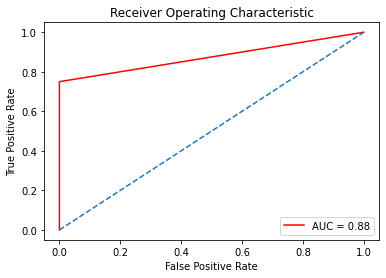

In [59]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

----------------------------------------------------------------------

# Approche III : “Modèle sur mesure avancé” 

- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet.

Pour cette partie nous allons tester deux modèles avec des word-embeddings differents :

        - un modèle RNN bidirectionnel LSTM avec Embedding  Keras par défaut
        - un modèle RNN bidirectionnel LSTM avec Embedding Glove

## Encodage et padding des textes

In [9]:
from keras.layers.experimental.preprocessing import TextVectorization

In [10]:
VOCAB_SIZE=100000
#encoder = TextVectorization(max_tokens=VOCAB_SIZE)
encoder = TextVectorization()

In [11]:
encoder.adapt(docs)

## Construction d'un modèle RNN bidirectionnel LSTM avec Embedding Keras par défaut

In [12]:
model = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [13]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [14]:
start_time = timeit.default_timer()

hist_new=model.fit(X_train, np.array(y_train), validation_data=(X_test, np.array(y_test)), epochs=2, batch_size=128)

elapsed = timeit.default_timer() - start_time
print("time : ",elapsed)

Epoch 1/2
8750/8750 [==============================] - 3024s 346ms/step - loss: 0.4734 - accuracy: 0.7588 - val_loss: 0.4529 - val_accuracy: 0.7738
Epoch 2/2
8750/8750 [==============================] - 2982s 341ms/step - loss: 0.4279 - accuracy: 0.7921 - val_loss: 0.4463 - val_accuracy: 0.7813
time :  6034.919294999999


## Evaluation du modèle

In [15]:
test_loss, test_acc = model.evaluate(X_test,np.array(y_test),verbose=2,batch_size=128)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

3750/3750 - 41s - loss: 0.4463 - accuracy: 0.7813
Test Loss: 0.4463244080543518
Test Accuracy: 0.7812749743461609


(0.0, 0.47566014528274536)

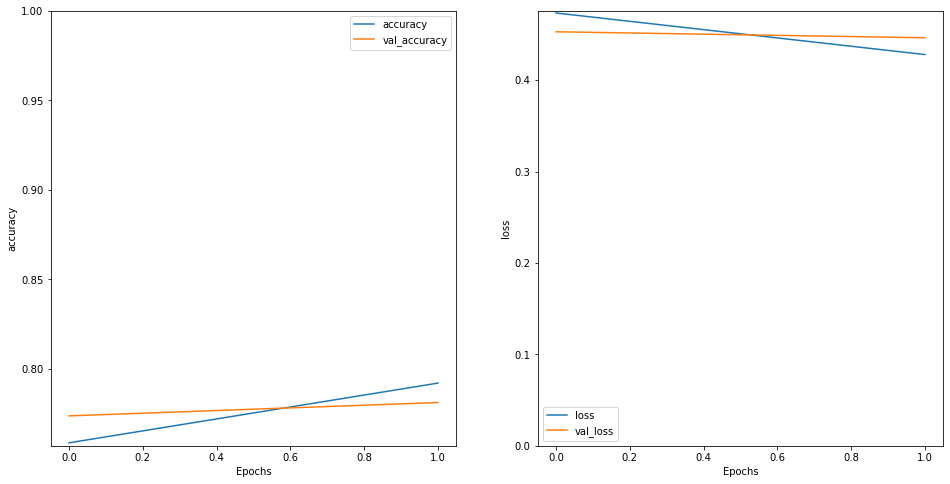

In [16]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(hist_new, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(hist_new, 'loss')
plt.ylim(0,None)

## Prédiction

In [17]:
exemple =["I'm happy","In love of this cute boy","the worst restaurant","I'm disapointed about that","The toilets are dirty.. terrible experience","I hate this restaurant","Came for lunch with my sister. We loved our Thai-style mains which were amazing with lots of flavour, very impressive for a vegetarian restaurant.","our visit was not successful. i ended up eating soup and soft foods for over a week due to a broken tooth at this restaurant. the local manager was fine but the senior management had an uncaring attitude. don't expect too much from this restaurant chain if you have problems."]

In [18]:
predictions = model.predict(exemple)

In [19]:
predictions

array([[ 2.189446  ],
       [ 3.9379952 ],
       [-2.4621313 ],
       [-3.0431445 ],
       [-2.3679492 ],
       [-1.7109745 ],
       [ 4.219369  ],
       [-0.38555768]], dtype=float32)

## Sauvegarde du modèle RNN à une couche

In [23]:
# serialize weights to HDF5
model.save("C:/Users/VM_compte/notebooks/P7/model_RNN")
print("Saved model to disk")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/VM_compte/notebooks/P7/model_RNN\assets
Saved model to disk


## Utilisation d'un 2éme Embedding : GLOVE

In [2]:
DF=pd.read_csv('Data_P7.csv')

In [3]:
def clean_text2(text) :
    vect_text = text.split()  # Split into words.
    vect_text = [token for token in vect_text if ((not token.startswith('@')) and (not token.isnumeric()))] 
    #    lemmatizer = WordNetLemmatizer()
    vect_text =[clean_word(token) for token in vect_text]
    vect_text =[token for token in vect_text if len(token) > 1]
    vect_text = [lemmatizer.lemmatize(token) for token in vect_text]
    text = ' '.join(token for token in vect_text)
    return text

In [6]:
start_time = timeit.default_timer()

DF['Text']=DF['Text'].apply(clean_text2)

elapsed = timeit.default_timer() - start_time
print("time : ",elapsed)

time :  442.68892669999997


In [7]:
docs=DF['Text'].values

In [8]:
from keras.preprocessing.text import one_hot, Tokenizer
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

## Encodage et padding des textes

In [9]:
# pad documents to a max length of 100 words
max_review_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_review_length, padding='post')

## Constitution des dataset d'entrainement et de test

In [10]:
labels=[1 if (x>0) else 0 for x in DF['Label']]

In [11]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(padded_docs, labels, test_size=0.3 ) # 30% des données dans le jeu de test


# Création d'un nouveau word Embedding

In [12]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [14]:
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_review_length, trainable=False)

## Construction d'un modèle RNN bidirectionnel LSTM avec Embedding Glove

In [15]:
# Reseau Neuronne normal
start_time = timeit.default_timer()

embed_dim = 64
lstm_out = 128
batch_size = 128
top_words = 10000


model_glove = Sequential([
    e,
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

print(model_glove.summary())

elapsed = timeit.default_timer() - start_time
print("time : ",elapsed)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          35400400  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 35,493,201
Trainable params: 92,801
Non-trainable params: 35,400,400
_________________________________________________________________
None
time :  2.427861099999973


In [16]:
model_glove.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [17]:
start_time = timeit.default_timer()

#Here we train the Network.
hist3=model_glove.fit(X_train, np.array(y_train), validation_data=(X_test, np.array(y_test)), epochs=3, batch_size=128)
elapsed = timeit.default_timer() - start_time
print("time : ",elapsed)

Epoch 1/4
8750/8750 [==============================] - 1639s 187ms/step - loss: 0.5662 - accuracy: 0.7110 - val_loss: 0.6378 - val_accuracy: 0.6573
Epoch 2/4
8750/8750 [==============================] - 1697s 194ms/step - loss: 0.5407 - accuracy: 0.7387 - val_loss: 0.5088 - val_accuracy: 0.7576
Epoch 3/4
8750/8750 [==============================] - 1695s 194ms/step - loss: 0.4891 - accuracy: 0.7714 - val_loss: 0.4699 - val_accuracy: 0.7814
Epoch 4/4
8750/8750 [==============================] - 1692s 193ms/step - loss: 0.4963 - accuracy: 0.7707 - val_loss: 0.4758 - val_accuracy: 0.7809
time :  6728.5133983000005


## Evaluation du modèle

(0.0, 0.6461744248867035)

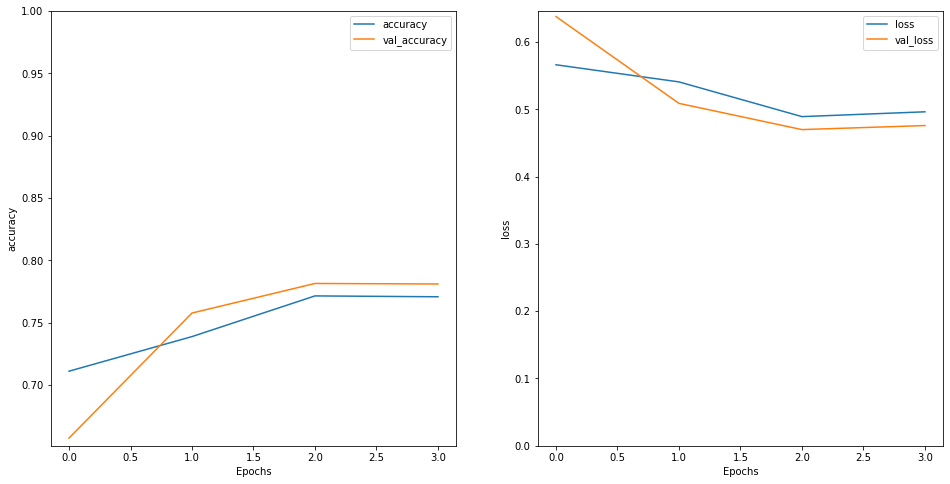

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(hist3, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(hist3, 'loss')
plt.ylim(0,None)

In [19]:
score, acc = model_glove.evaluate(X_test,np.array(y_test),verbose=2,batch_size=128)

3750/3750 - 196s - loss: 0.4758 - accuracy: 0.7809


In [20]:
print ("Score : %.2f" %(score))
print ("Validation Accuracy : %.2f" %(acc))

Score : 0.48
Validation Accuracy : 0.78
